In [ ]:
# Mount Google Drive (if your dataset is stored in Google Drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




**Data Preprocessing**

In [ ]:
import os
import cv2
import numpy as np

dataset_path = "/content/drive/MyDrive/rice_leaf_diseases_1"

images = []
labels = []

class_to_disease = {
    "Bacterial leaf blight": "Bacterial Leaf Blight",
    "Brown spot": "Brown Spot",
    "Leaf smut": "Leaf Smut",
    "Healthy": "Healthy"
}

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels.append(class_to_disease[class_folder])

images = np.array(images)
labels = np.array(labels)

disease_names = np.unique(labels)

for i, disease_name in enumerate(disease_names):
    print("Disease Name:", disease_name, " - Label:", i)


Disease Name: Bacterial Leaf Blight  - Label: 0
Disease Name: Brown Spot  - Label: 1
Disease Name: Healthy  - Label: 2
Disease Name: Leaf Smut  - Label: 3


In [ ]:
class_names = np.unique(labels)
print("Class names:", class_names)

Class names: ['Bacterial Leaf Blight' 'Brown Spot' 'Healthy' 'Leaf Smut']


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Normalize pixel values to [0, 1]
images = images.astype('float32') / 255.0

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)



**Train - Test - Split**

In [ ]:
# Split the dataset into training and testing sets
images, labels = shuffle(images, labels, random_state = 42)
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42)

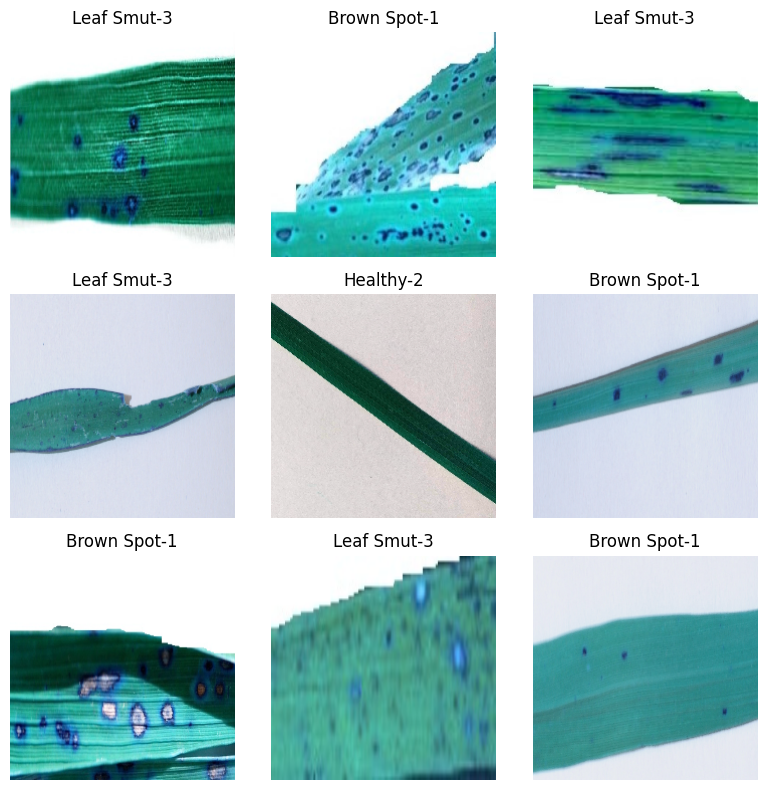

In [ ]:
import matplotlib.pyplot as plt

label_to_class = {label_idx: class_name for label_idx, class_name in enumerate(label_encoder.classes_)}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
axes = axes.ravel()

for i in range(9):
    rand_index = np.random.randint(0, len(images))
    axes[i].imshow(images[rand_index])
    label_idx = labels[rand_index]
    class_name = label_to_class[label_idx]
    axes[i].set_title(f"{class_name}-{label_idx}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()



**Feature Extraction**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features from the images using the VGG16 model
train_features = base_model.predict(train_images)
test_features = base_model.predict(test_images)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


**Model Training using SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Flatten the feature vectors
train_features_flat = train_features.reshape(train_features.shape[0], -1)

# Initialize an SVM classifier
svm = SVC()

param_grid = {'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001]}


grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(train_features_flat, train_labels)

# Get the best SVM model
svm_model = grid_search.best_estimator_
# Train the SVM model
svm_model.fit(train_features_flat, train_labels)



SVC(C=10, gamma=0.001)

**Model Evaluation using SVM**

Accuracy: 0.71875
[[ 2  1  0  1]
 [ 2  5  0  5]
 [ 0  0 10  0]
 [ 0  0  0  6]]


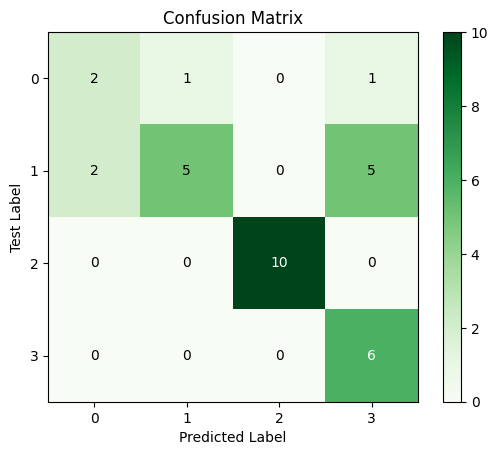

In [ ]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

# Reshape the test features
test_features_flat = test_features.reshape(test_features.shape[0], -1)

# Predict labels for the test set
predicted_labels = svm_model.predict(test_features_flat)

# Calculate accuracy and other evaluation metrics
accuracy = accuracy_score(test_labels, predicted_labels)
report = classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_)

print("Accuracy:", accuracy)
print(confusion_matrix(test_labels,predicted_labels))

cm = confusion_matrix(test_labels, predicted_labels)
classes = np.unique(test_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# Label the matrix with the counts
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')

# Add axis labels
plt.xlabel('Predicted Label')
plt.ylabel('Test Label')

# Show the plot
plt.show()


In [ ]:
train_predicted_labels = svm_model.predict(train_features_flat)

train_accuracy_svm = accuracy_score(train_labels, train_predicted_labels)

print("Training Accuracy (SVM):", train_accuracy_svm)


Training Accuracy (SVM): 1.0


**SVM Model Prediction**

In [ ]:
from skimage.transform import resize

image_path = '/content/drive/MyDrive/rice_leaf_diseases_1/Bacterial leaf blight/DSC_0372.JPG'
img = cv2.imread(image_path)
resized_img = resize(img, (224, 224))
test_feature = base_model.predict(np.expand_dims(resized_img, axis=0))
test_feature_flat = test_feature.reshape(1, -1)

predicted_label = svm_model.predict(test_feature_flat)

predicted_disease_name = label_encoder.inverse_transform(predicted_label)[0]

print("Predicted disease:",predicted_disease_name)
plt.imshow(resized_img)
plt.axis('off')
plt.title("Predicted Disease using SVM: " + predicted_disease_name)
plt.show()


print("Remedies : ")
if(predicted_disease_name == "Bacterial Leaf Blight"):
     print('Use disease-free seeds and rotate paddy with non-host crops.\nApply copper-based sprays (such as Bordeaux mixture or copper hydroxide) or \nbactericides like streptomycin sulfate.')
if(predicted_disease_name == "Brown Spot"):
     print("Plant paddy at the recommended time and use resistant varieties.\nApply fungicides such as propiconazole or tebuconazole as preventive measures or at the onset of symptoms.")
if(predicted_disease_name == "Healthy"):
     print("Its Healthy leaf .. No remedies Required")
if(predicted_disease_name == "Leaf Smut"):
     print("Treat paddy seeds with recommended fungicides like carbendazim or thiophanate-methyl before planting.\nApply fungicides during the early stages of the crop as a preventive measure against leaf smut.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted disease: Bacterial Leaf Blight


Remedies : 
Use disease-free seeds and rotate paddy with non-host crops.
Apply copper-based sprays (such as Bordeaux mixture or copper hydroxide) or 
bactericides like streptomycin sulfate.


**Model Training using Decision Tree**

Accuracy: 0.625
[[ 2  1  0  1]
 [ 2  5  0  5]
 [ 0  0 10  0]
 [ 0  0  0  6]]


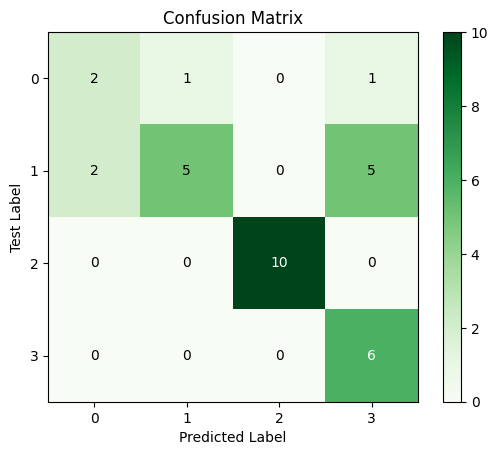

In [ ]:
from sklearn.tree import DecisionTreeClassifier

train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

tree = DecisionTreeClassifier()

tree.fit(train_features_flat, train_labels)

Dt_model = tree.fit(train_features_flat, train_labels)

accuracy_d= tree.score(test_features_flat, test_labels)
print("Accuracy:", accuracy_d)
print(confusion_matrix(test_labels,predicted_labels))
dt = confusion_matrix(test_labels, predicted_labels)
classes = np.unique(test_labels)

# Plot the confusion matrix
plt.imshow(dt, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# Label the matrix with the counts
thresh = dt.max() / 2.0
for i, j in np.ndindex(dt.shape):
    plt.text(j, i, dt[i, j], ha='center', va='center', color='white' if dt[i, j] > thresh else 'black')

# Add axis labels
plt.xlabel('Predicted Label')
plt.ylabel('Test Label')

# Show the plot
plt.show()

In [ ]:
train_predicted_labels_DT = Dt_model.predict(train_features_flat)

train_accuracy_DecisionTree = accuracy_score(train_labels, train_predicted_labels_DT)

print("Training Accuracy (Decision Tree):", train_accuracy_DecisionTree)

Training Accuracy (Decision Tree): 1.0


**Desicion Tree Model Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted disease: Leaf Smut


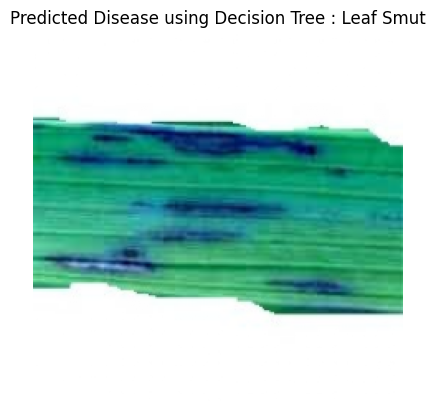

Remedies : 
Treat paddy seeds with recommended fungicides like carbendazim or 
thiophanate-methyl before planting.
Apply fungicides during the early stages of the crop as a preventive 
measure against leaf smut.


In [ ]:
from skimage.transform import resize

image_path = '/content/drive/MyDrive/rice_leaf_diseases_1/Leaf smut/DSC_0504.jpg'
img = cv2.imread(image_path)
resized_img = resize(img, (224, 224))
test_feature = base_model.predict(np.expand_dims(resized_img, axis=0))
test_feature_flat = test_feature.reshape(1, -1)

predicted_label = Dt_model.predict(test_feature_flat)

predicted_disease_name = label_encoder.inverse_transform(predicted_label)[0]

print("Predicted disease:",predicted_disease_name)
plt.imshow(resized_img)
plt.axis('off')
plt.title("Predicted Disease using Decision Tree : " +  predicted_disease_name)
plt.show()


print("Remedies : ")
if(predicted_disease_name == "Bacterial Leaf Blight"):
     print('Use disease-free seeds and rotate paddy with non-host crops.\nApply copper-based sprays (such as Bordeaux mixture or copper hydroxide) or bactericides like streptomycin sulfate.')
if(predicted_disease_name == "Brown Spot"):
     print("Plant paddy at the recommended time and use resistant varieties.\nApply fungicides such as propiconazole or tebuconazole as preventive measures or at the onset of symptoms.")
if(predicted_disease_name == "Healthy"):
     print("Its Healthy leaf .. No remedies Required")
if(predicted_disease_name == "Leaf Smut"):
     print("Treat paddy seeds with recommended fungicides like carbendazim or \nthiophanate-methyl before planting.\nApply fungicides during the early stages of the crop as a preventive \nmeasure against leaf smut.")

**Model Training using KNN**

Accuracy: 0.65625
[[ 2  1  0  1]
 [ 2  5  0  5]
 [ 0  0 10  0]
 [ 0  0  0  6]]


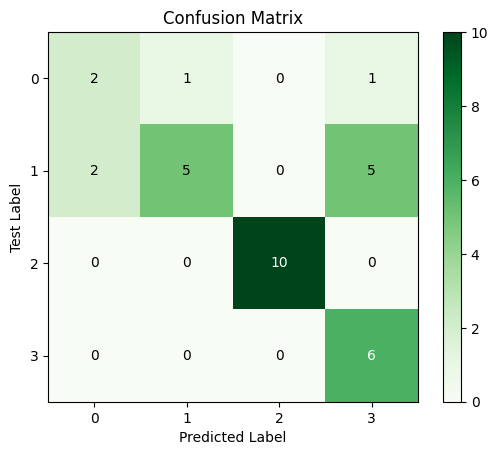

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(train_features_flat, train_labels)

knn_model = knn.fit(train_features_flat, train_labels)

accuracy_knn = knn.score(test_features_flat, test_labels)
print("Accuracy:", accuracy_knn)
print(confusion_matrix(test_labels,predicted_labels))
kcm = confusion_matrix(test_labels, predicted_labels)
classes = np.unique(test_labels)

# Plot the confusion matrix
plt.imshow(kcm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# Label the matrix with the counts
thresh = kcm.max() / 2.0
for i, j in np.ndindex(kcm.shape):
    plt.text(j, i, kcm[i, j], ha='center', va='center', color='white' if kcm[i, j] > thresh else 'black')

# Add axis labels
plt.xlabel('Predicted Label')
plt.ylabel('Test Label')

# Show the plot
plt.show()

**KNN Model Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted disease: Brown Spot


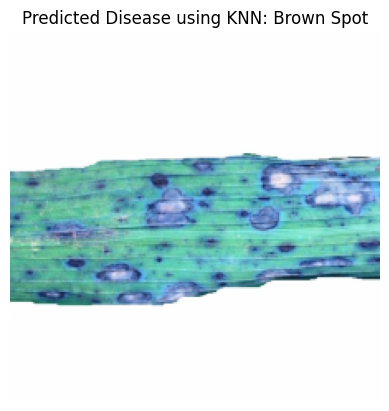

Remedies : 
Plant paddy at the recommended time and use resistant varieties.
Apply fungicides such as propiconazole or tebuconazole as preventive measures or at the onset of symptoms.


In [ ]:
from skimage.transform import resize

image_path = '/content/drive/MyDrive/rice_leaf_diseases_1/Brown spot/DSC_0113.jpg'
img = cv2.imread(image_path)
resized_img = resize(img, (224, 224))
test_feature = base_model.predict(np.expand_dims(resized_img, axis=0))
test_feature_flat = test_feature.reshape(1, -1)

predicted_label = knn_model.predict(test_feature_flat)

predicted_disease_name = label_encoder.inverse_transform(predicted_label)[0]

print("Predicted disease:",predicted_disease_name)
plt.imshow(resized_img)
plt.axis('off')
plt.title("Predicted Disease using KNN: " + predicted_disease_name)
plt.show()


print("Remedies : ")
if(predicted_disease_name == "Bacterial Leaf Blight"):
     print('Use disease-free seeds and rotate paddy with non-host crops.\nApply copper-based sprays (such as Bordeaux mixture or copper hydroxide) or bactericides like streptomycin sulfate.')
if(predicted_disease_name == "Brown Spot"):
     print("Plant paddy at the recommended time and use resistant varieties.\nApply fungicides such as propiconazole or tebuconazole as preventive measures or at the onset of symptoms.")
if(predicted_disease_name == "Healthy"):
     print("Its Healthy leaf .. No remedies Required")
if(predicted_disease_name == "Leaf Smut"):
     print("Treat paddy seeds with recommended fungicides like carbendazim or \nthiophanate-methyl before planting.\nApply fungicides during the early stages of the crop as a preventive \nmeasure against leaf smut.")

**Model Training using Random Forest**

Accuracy: 0.8125
[[ 2  1  0  1]
 [ 2  5  0  5]
 [ 0  0 10  0]
 [ 0  0  0  6]]


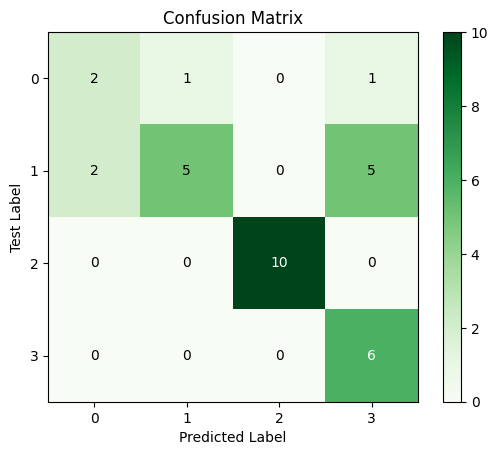

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(train_features_flat, train_labels)
rf_model = rf.fit(train_features_flat, train_labels)

accuracy_r = rf.score(test_features_flat, test_labels)
print("Accuracy:", accuracy_r)
print(confusion_matrix(test_labels,predicted_labels))

rdf = confusion_matrix(test_labels, predicted_labels)
classes = np.unique(test_labels)

# Plot the confusion matrix
plt.imshow(rdf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# Label the matrix with the counts
thresh = rdf.max() / 2.0
for i, j in np.ndindex(kcm.shape):
    plt.text(j, i, rdf[i, j], ha='center', va='center', color='white' if rdf[i, j] > thresh else 'black')

# Add axis labels
plt.xlabel('Predicted Label')
plt.ylabel('Test Label')

# Show the plot
plt.show()

**RandomForest Model Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted disease: Healthy


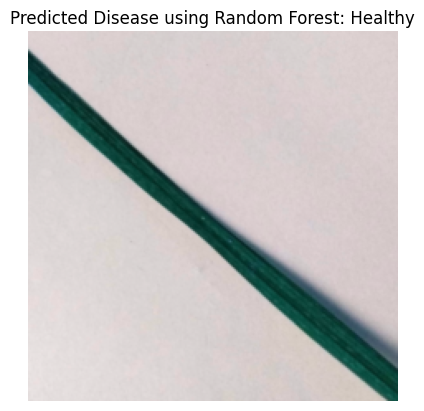

Remedies : 
Its Healthy leaf .. No remedies Required


In [ ]:
from skimage.transform import resize

image_path = '/content/drive/MyDrive/rice_leaf_diseases_1/Healthy/IMG_20190419_175230.jpg'
img = cv2.imread(image_path)
resized_img = resize(img, (224, 224))
test_feature = base_model.predict(np.expand_dims(resized_img, axis=0))
test_feature_flat = test_feature.reshape(1, -1)

predicted_label = rf_model.predict(test_feature_flat)

predicted_disease_name = label_encoder.inverse_transform(predicted_label)[0]

print("Predicted disease:",predicted_disease_name)
plt.imshow(resized_img)
plt.axis('off')
plt.title("Predicted Disease using Random Forest: " + predicted_disease_name)
plt.show()


print("Remedies : ")
if(predicted_disease_name == "Bacterial Leaf Blight"):
     print('Use disease-free seeds and rotate paddy with non-host crops.\nApply copper-based sprays (such as Bordeaux mixture or copper hydroxide) or bactericides like streptomycin sulfate.')
if(predicted_disease_name == "Brown Spot"):
     print("Plant paddy at the recommended time and use resistant varieties.\nApply fungicides such as propiconazole or tebuconazole as preventive measures or at the onset of symptoms.")
if(predicted_disease_name == "Healthy"):
     print("Its Healthy leaf .. No remedies Required")
if(predicted_disease_name == "Leaf Smut"):
     print("Treat paddy seeds with recommended fungicides like carbendazim or thiophanate-methyl before planting.\nApply fungicides during the early stages of the crop as a preventive measure against leaf smut.")

In [ ]:
print("Accuracy (SVM):", accuracy)
print("Accuracy (Decision Tree): ", accuracy_d)
print("Accuracy (Random Forest): ",accuracy_r)
print("Accuracy (KNN): ", accuracy_knn)

Accuracy (SVM): 0.71875
Accuracy (Decision Tree):  0.625
Accuracy (Random Forest):  0.8125
Accuracy (KNN):  0.65625


In [ ]:
from tabulate import tabulate

# Example accuracy values (replace with your own)
accuracy_values = {
    'SVM': accuracy,
    'Decision Tree': accuracy_d,
    'KNN': accuracy_knn,
    'Random Forest': accuracy_r
}

# Prepare the data for the table
table_data = []
for model, accuracy in accuracy_values.items():
    table_data.append([model, accuracy])

# Set the headers for the table
headers = ['Model', 'Accuracy']

# Generate the table
table = tabulate(table_data, headers, tablefmt='fancy_grid')

# Print the table
print(table)

╒═══════════════╤════════════╕
│ Model         │   Accuracy │
╞═══════════════╪════════════╡
│ SVM           │    0.71875 │
├───────────────┼────────────┤
│ Decision Tree │    0.625   │
├───────────────┼────────────┤
│ KNN           │    0.65625 │
├───────────────┼────────────┤
│ Random Forest │    0.8125  │
╘═══════════════╧════════════╛


**AREA INTENSITY DETECTION FOR BACTERIAL LEAF BLIGHT DISEASE IMAGE**

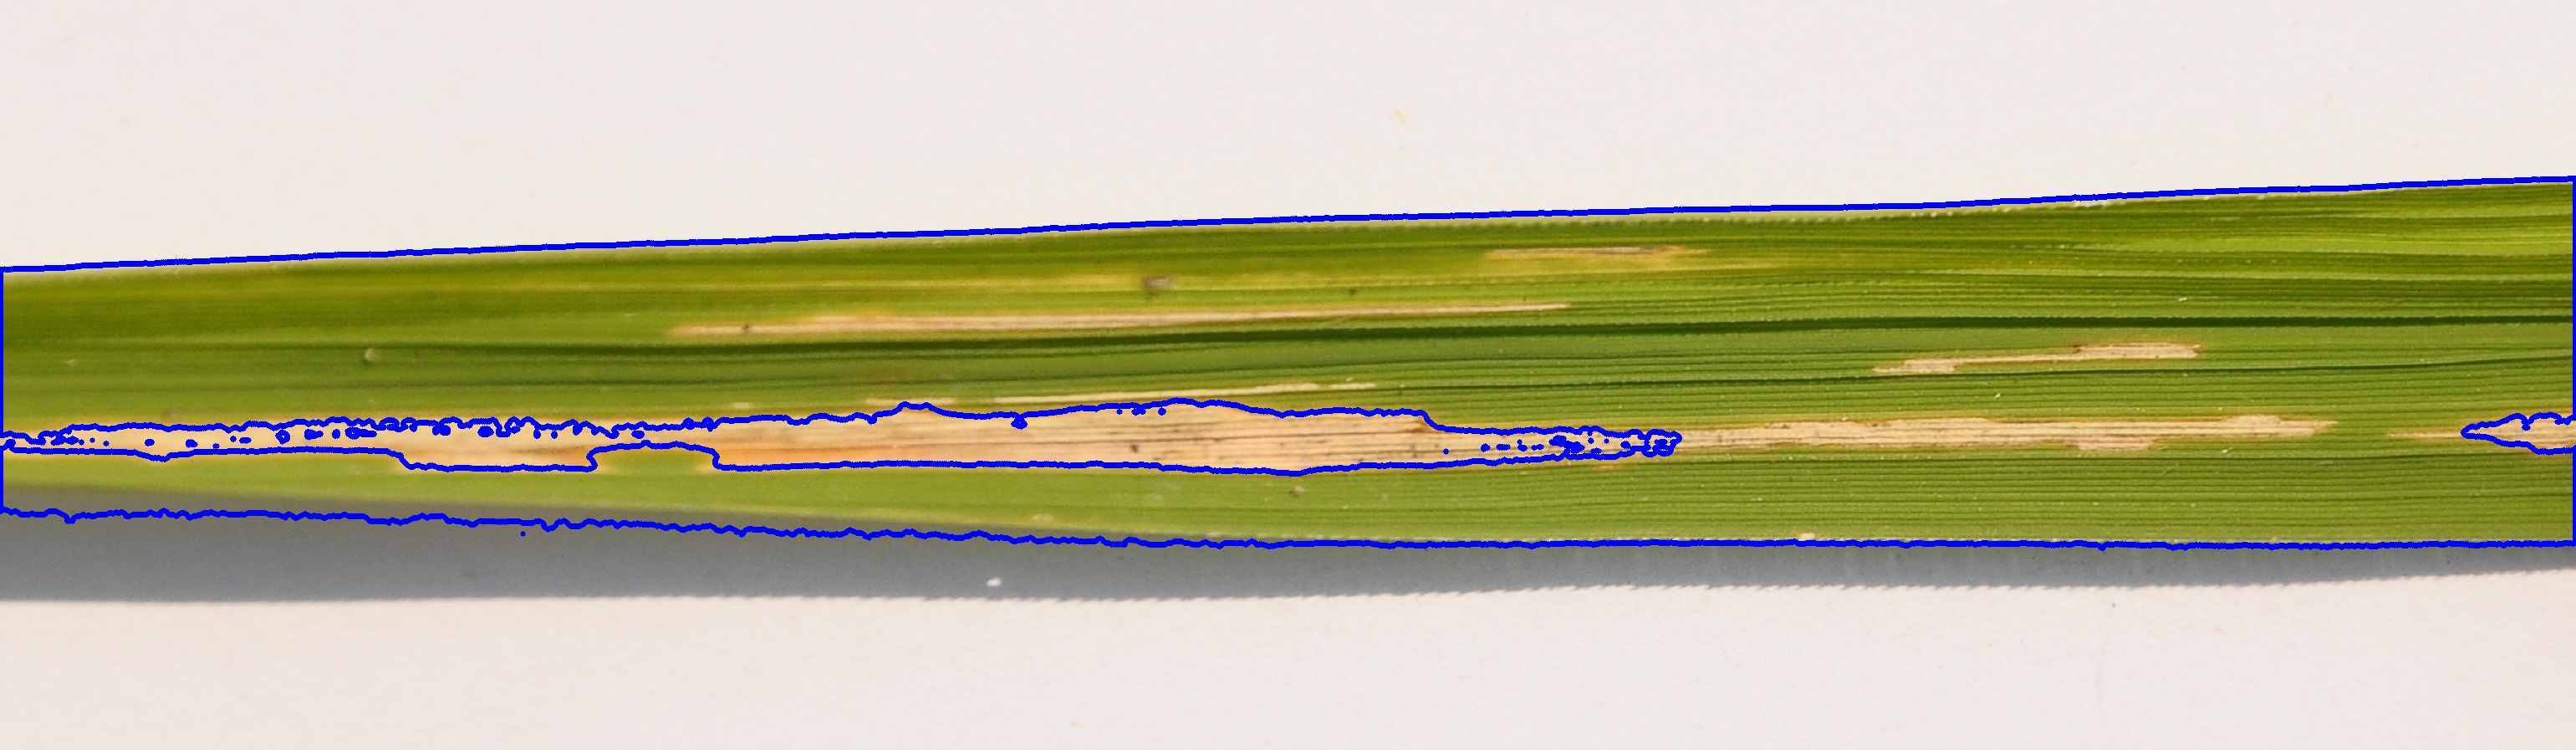

Total affected area in pixels: 1055472.5 pixels
Total affected area in percentage: 38.19 %


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/rice_leaf_diseases_1/Bacterial leaf blight/DSC_0372.JPG')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([20, 50, 50])  # Adjusting these values according to specific disease characteristics
upper_color = np.array([40, 255, 255])  # Adjusting these values according to specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)

# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]

# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)
    affected_area += area

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Display the image with disease-affected areas highlighted
cv2_imshow(image)

# Print the total affected area and percentage
print(f"Total affected area in pixels: {affected_area} pixels")
print(f"Total affected area in percentage: {affected_area_percentage:.2f} %")


**AREA INTENSITY DETECTION FOR BROWN SPOT DISEASE IMAGE**

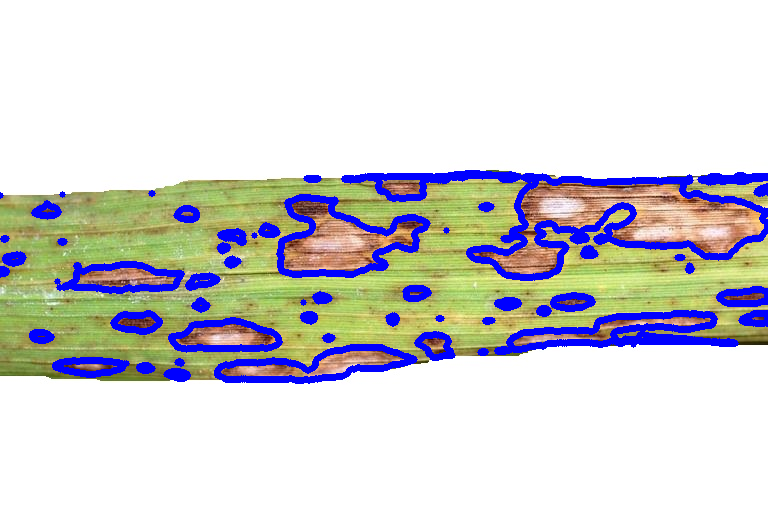

Total affected area in pixels: 38421.0 pixels
Total affected area in percentage: 9.73 %


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/rice_leaf_diseases_1/Brown spot/DSC_0113.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([0, 50, 50])  # Adjust these values according to specific disease characteristics
upper_color = np.array([20, 255, 255])  # Adjust these values according to specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)

# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]

# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)
    affected_area += area

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Display the image with disease-affected areas highlighted
cv2_imshow(image)

# Print the total affected area and percentage
print(f"Total affected area in pixels: {affected_area} pixels")
print(f"Total affected area in percentage: {affected_area_percentage:.2f} %")


**AREA INTENSITY DEETECTION FOR HEALTHY LEAF IMAGE**

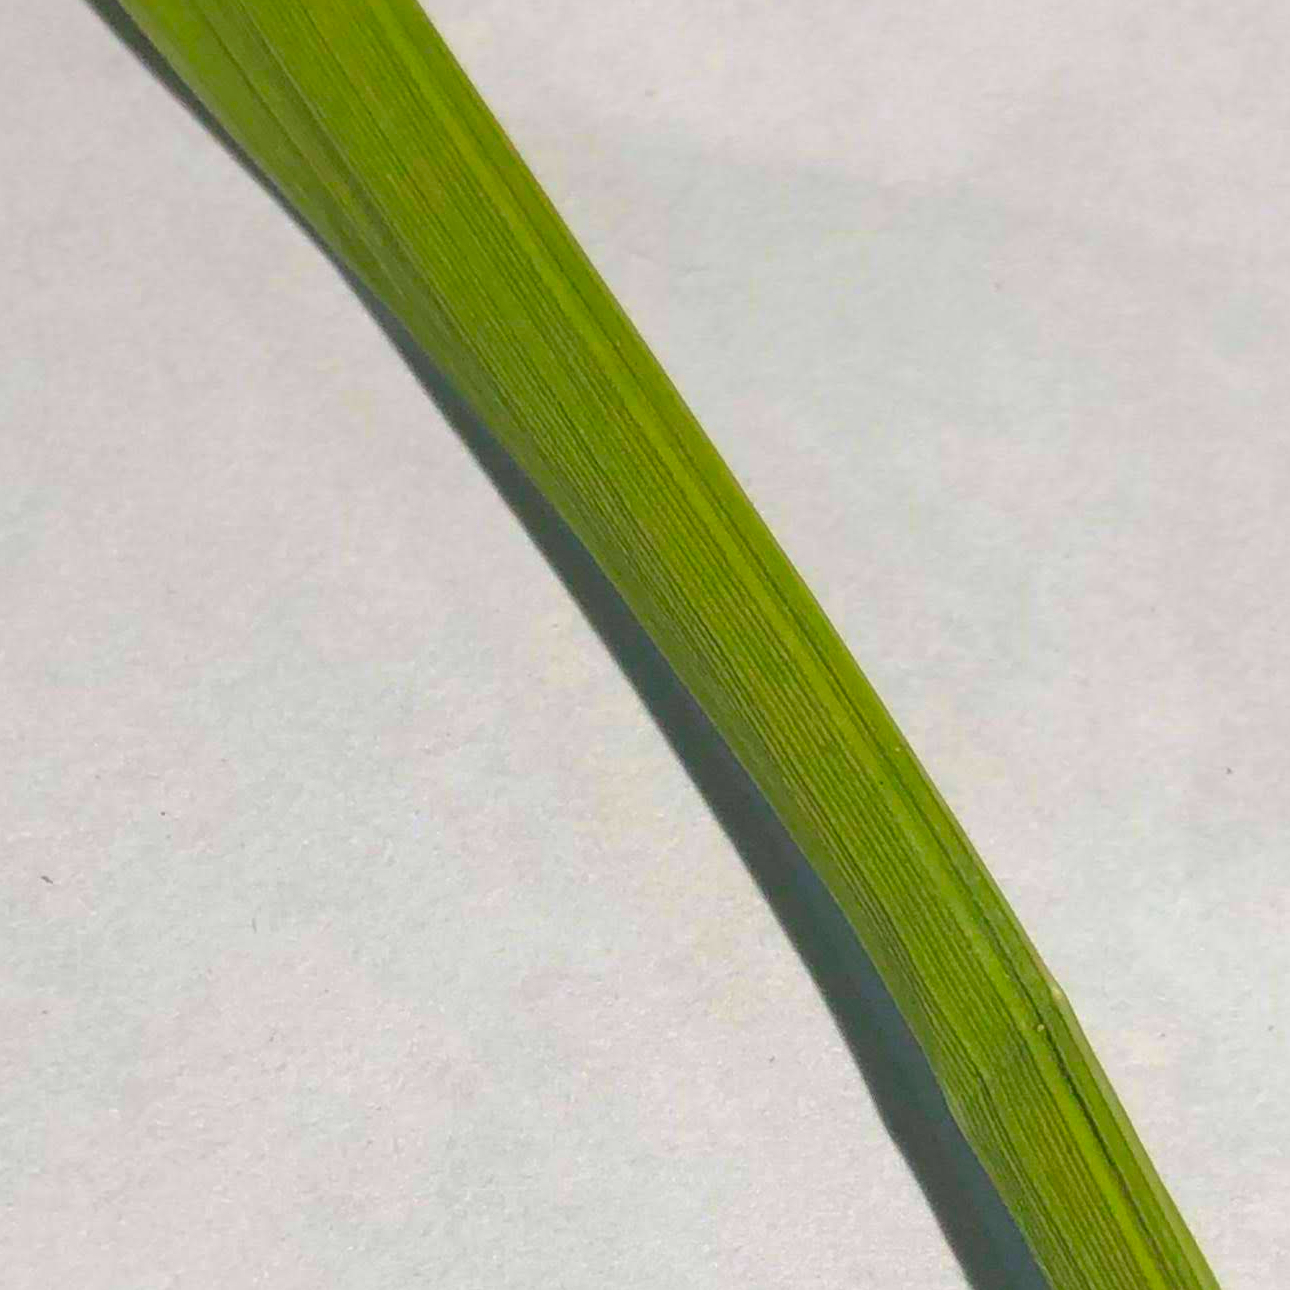

Total affected area in pixels: 0 pixels
Disease-affected area percentage: 0.0 %


In [27]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/rice_leaf_diseases_1/Healthy/IMG_3233.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([0, 50, 50])  # Adjust these values according to your specific disease characteristics
upper_color = np.array([10, 255, 255])  # Adjust these values according to your specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)

# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]

# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)
    # Update the total affected area
    affected_area += area

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Display the image with disease-affected areas highlighted
cv2_imshow(image)

# Print the total affected area and percentage
print("Total affected area in pixels:", affected_area, "pixels")
print("Disease-affected area percentage:", affected_area_percentage, "%")


**AREA INTENSITY FOR LEAF SMUT DISEASE IMAGE LEAF**

Total affected Area in mm^2 : 72.50000000000001 mm^2
Total affected area in pixels: 3132.0 pixels
Total affected area in percentage: 6.264 %


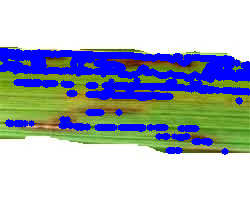

In [28]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


# Load the leaf image
image = cv2.imread('/content/drive/MyDrive/rice_leaf_diseases_1/Leaf smut/DSC_0504.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)



# Defining the lower and upper color thresholds for disease-affected areas
lower_color = np.array([0, 255, 50])  # Adjust these values according to your specific disease characteristics
upper_color = np.array([180, 255, 255])  # Adjust these values according to your specific disease characteristics

# Threshold the image to get disease-affected areas
mask = cv2.inRange(hsv, lower_color, upper_color)




# Apply a morphological operation to improve the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

#contour_image = np.zeros_like(image)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
cv2.drawContours(image, contours, -1, (255, 0, 0), 6)  # Draw blue contours around disease-affected areas

# Calculate the total leaf area
total_area = image.shape[0] * image.shape[1]

# Initialize a variable to store the total affected area
affected_area = 0

# Iterate over the contours
for contour in contours:
    # Calculate the area of each contour
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    length = h
    width = w

    # Assuming you have the pixel resolution or scale factor in mm/pixel
    pixel_resolution_mm = 0.1  # Pixel resolution in mm/pixel

    # Calculate the length and width in millimeters
    length_mm = length * pixel_resolution_mm
    width_mm = width * pixel_resolution_mm

    # Update the total affected area
    affected_area += area

    # Calculate the affected area in mm^2
    affected_area_mm2 = length_mm * width_mm

# Print the affected area
print("Total affected Area in mm^2 : {} mm^2".format(affected_area_mm2))

# Print the total affected area
print("Total affected area in pixels:", affected_area, "pixels")

# Calculate the affected area percentage
affected_area_percentage = (affected_area / total_area) * 100

# Print the affected area percentage
print("Total affected area in percentage:", affected_area_percentage, "%")

# Display the image with disease-affected areas highlighted
cv2_imshow(image)


Accuracy (Logistic Regression): 0.78125
[[ 2  1  0  1]
 [ 1  7  0  4]
 [ 0  0 10  0]
 [ 0  0  0  6]]


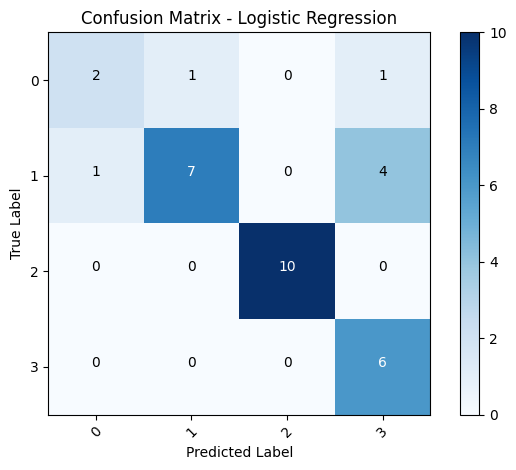

In [29]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression classifier
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg.fit(train_features_flat, train_labels)

# Predict on test set
predicted_labels_logreg = logreg.predict(test_features_flat)

# Calculate accuracy
accuracy_logreg = accuracy_score(test_labels, predicted_labels_logreg)
print("Accuracy (Logistic Regression):", accuracy_logreg)

# Confusion Matrix
cm_logreg = confusion_matrix(test_labels, predicted_labels_logreg)
print(cm_logreg)

# Plot Confusion Matrix
plt.imshow(cm_logreg, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add counts to the matrix
thresh = cm_logreg.max() / 2.
for i, j in np.ndindex(cm_logreg.shape):
    plt.text(j, i, cm_logreg[i, j],
             horizontalalignment="center",
             color="white" if cm_logreg[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


Accuracy (Gradient Boosting): 0.65625
[[ 2  2  0  0]
 [ 3  5  0  4]
 [ 0  0 10  0]
 [ 2  0  0  4]]


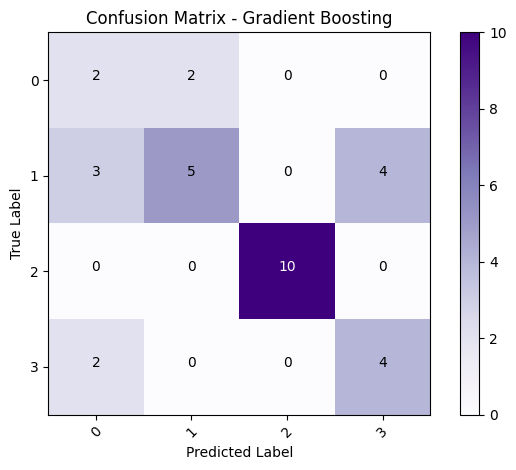

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting classifier
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model
gbc.fit(train_features_flat, train_labels)

# Predict on test set
predicted_labels_gbc = gbc.predict(test_features_flat)

# Calculate accuracy
accuracy_gbc = accuracy_score(test_labels, predicted_labels_gbc)
print("Accuracy (Gradient Boosting):", accuracy_gbc)

# Confusion Matrix
cm_gbc = confusion_matrix(test_labels, predicted_labels_gbc)
print(cm_gbc)

# Plot Confusion Matrix
plt.imshow(cm_gbc, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion Matrix - Gradient Boosting')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add counts to the matrix
thresh = cm_gbc.max() / 2.
for i, j in np.ndindex(cm_gbc.shape):
    plt.text(j, i, cm_gbc[i, j],
             horizontalalignment="center",
             color="white" if cm_gbc[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [31]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize AdaBoost classifier
ada = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train the model
ada.fit(train_features_flat, train_labels)

# Predict on test set
predicted_labels_ada = ada.predict(test_features_flat)

# Calculate accuracy
accuracy_ada = accuracy_score(test_labels, predicted_labels_ada)
print("Accuracy (AdaBoost):", accuracy_ada)

# Confusion Matrix
cm_ada = confusion_matrix(test_labels, predicted_labels_ada)
print(cm_ada)

# Plot Confusion Matrix
plt.imshow(cm_ada, interpolation='nearest', cmap=plt.cm.Oranges)
plt.title('Confusion Matrix - AdaBoost')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add counts to the matrix
thresh = cm_ada.max() / 2.
for i, j in np.ndindex(cm_ada.shape):
    plt.text(j, i, cm_ada[i, j],
             horizontalalignment="center",
             color="white" if cm_ada[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy (AdaBoost): 0.40625
[[ 3  1  0  0]
 [11  0  1  0]
 [ 0  0 10  0]
 [ 6  0  0  0]]


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - accuracy: 0.3354 - loss: 1.7512 - val_accuracy: 0.5312 - val_loss: 0.9408
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.6885 - loss: 0.7883 - val_accuracy: 0.5938 - val_loss: 0.7611
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7646 - loss: 0.5998 - val_accuracy: 0.8750 - val_loss: 0.4914
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.8781 - loss: 0.4400 - val_accuracy: 0.8125 - val_loss: 0.5166
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.8792 - loss: 0.3613 - val_accuracy: 0.7188 - val_loss: 0.6277
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8781 - loss: 0.3582 - val_accuracy: 0.9062 - val_loss: 0.4031
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8906 - loss: 0.2809 - val_accuracy: 0.7812 - val_loss: 0.4617
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9312 - loss: 0.2333 - val_accuracy: 0.6875 - val_loss:

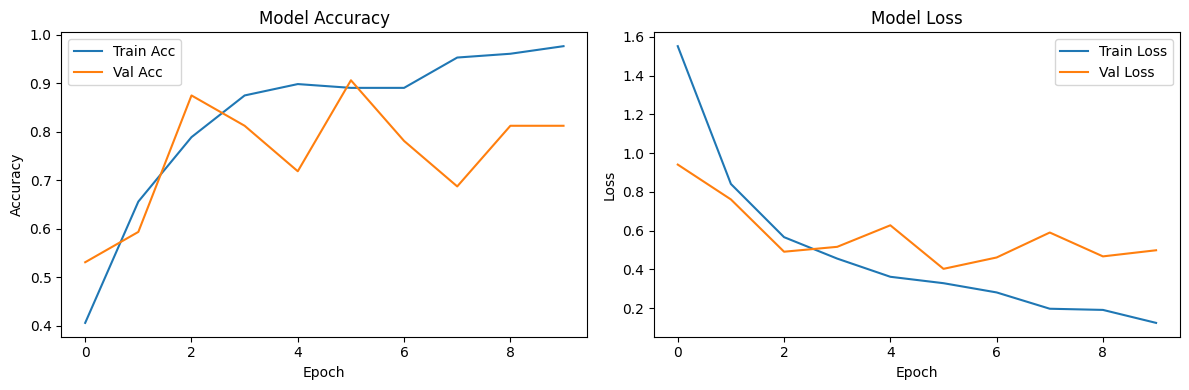

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
[[ 2  1  0  1]
 [ 1  8  0  3]
 [ 0  0 10  0]
 [ 0  0  0  6]]


In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
train_labels_cat = to_categorical(train_labels, num_classes)
test_labels_cat = to_categorical(test_labels, num_classes)

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels_cat,
                    epochs=10,
                    batch_size=32,
                    validation_data=(test_images, test_labels_cat))

# Evaluate the model
loss, accuracy_dl = model.evaluate(test_images, test_labels_cat)
print("Accuracy (Fine-Tuned VGG16):", accuracy_dl)

# Plot Training History
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
predictions = model.predict(test_images)
predicted_labels_dl = np.argmax(predictions, axis=1)
cm_dl = confusion_matrix(test_labels, predicted_labels_dl)
print(cm_dl)

# Plot Confusion Matrix
plt.imshow(cm_dl, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Fine-Tuned VGG16')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add counts to the matrix
thresh = cm_dl.max() / 2.
for i, j in np.ndindex(cm_dl.shape):
    plt.text(j, i, cm_dl[i, j],
             horizontalalignment="center",
             color="white" if cm_dl[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.1771 - loss: 1.3894 - val_accuracy: 0.5000 - val_loss: 1.1188
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4448 - loss: 1.2282 - val_accuracy: 0.5625 - val_loss: 1.0309
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4927 - loss: 1.1268 - val_accuracy: 0.5938 - val_loss: 0.8192
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5365 - loss: 0.9883 - val_accuracy: 0.7188 - val_loss: 0.7177
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6531 - loss: 0.8276 - val_accuracy: 0.7188 - val_loss: 0.6575
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6406 - loss: 0.7357 - val_accuracy: 0.6562 - val_loss: 0.6557
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7990 - loss: 0.5949 - val_accuracy: 0.7812 - val_loss: 0.5476
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6948 - loss: 0.7156 - val_accuracy: 0.7812 - val_loss: 0.5765
E

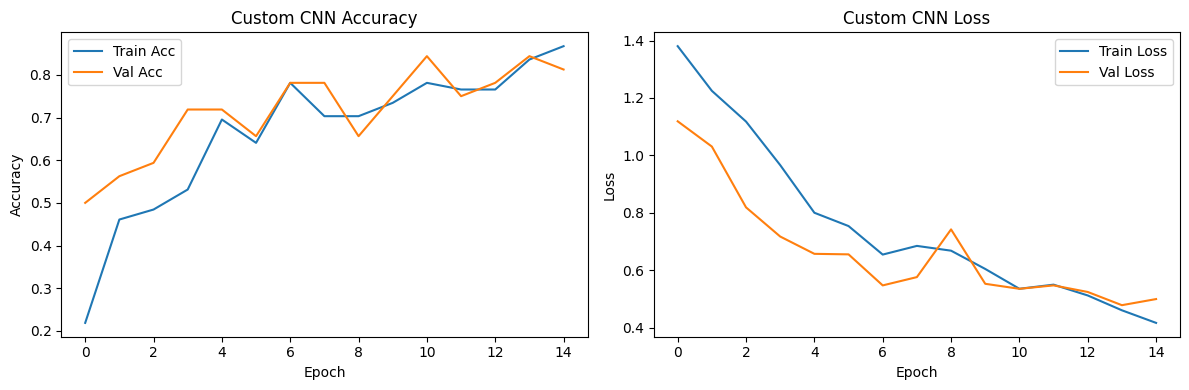

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
[[ 3  0  0  1]
 [ 1  8  0  3]
 [ 0  0 10  0]
 [ 1  0  0  5]]


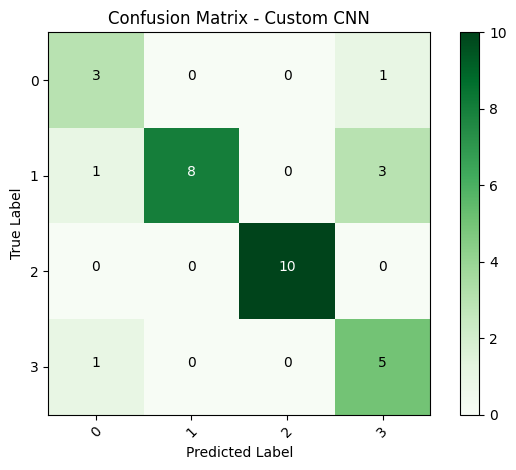

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Define the custom CNN model
custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
custom_cnn.compile(optimizer=Adam(learning_rate=1e-4),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model
history_cnn = custom_cnn.fit(train_images, train_labels_cat,
                             epochs=15,
                             batch_size=32,
                             validation_data=(test_images, test_labels_cat))

# Evaluate the model
loss_cnn, accuracy_custom_cnn = custom_cnn.evaluate(test_images, test_labels_cat)
print("Accuracy (Custom CNN):", accuracy_custom_cnn)

# Plot Training History
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.title('Custom CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Custom CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
predictions_cnn = custom_cnn.predict(test_images)
predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)
cm_custom_cnn = confusion_matrix(test_labels, predicted_labels_cnn)
print(cm_custom_cnn)

# Plot Confusion Matrix
plt.imshow(cm_custom_cnn, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix - Custom CNN')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add counts to the matrix
thresh = cm_custom_cnn.max() / 2.
for i, j in np.ndindex(cm_custom_cnn.shape):
    plt.text(j, i, cm_custom_cnn[i, j],
             horizontalalignment="center",
             color="white" if cm_custom_cnn[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [34]:
from tabulate import tabulate

# Gather all accuracy scores
accuracy_values_extended = {
    'SVM': accuracy,
    'Decision Tree': accuracy_d,
    'KNN': accuracy_knn,
    'Random Forest': accuracy_r,
    'Logistic Regression': accuracy_logreg,
    'Gradient Boosting': accuracy_gbc,
    'AdaBoost': accuracy_ada,
    'Fine-Tuned VGG16': accuracy_dl,
    'Custom CNN': accuracy_custom_cnn
}

# Prepare the data for the table
table_data_extended = []
for model, acc in accuracy_values_extended.items():
    table_data_extended.append([model, round(acc, 4)])

# Set the headers for the table
headers_extended = ['Model', 'Accuracy']

# Generate the table
table_extended = tabulate(table_data_extended, headers_extended, tablefmt='fancy_grid')

# Print the table
print(table_extended)


╒═════════════════════╤════════════╕
│ Model               │   Accuracy │
╞═════════════════════╪════════════╡
│ SVM                 │     0.8125 │
├─────────────────────┼────────────┤
│ Decision Tree       │     0.625  │
├─────────────────────┼────────────┤
│ KNN                 │     0.6562 │
├─────────────────────┼────────────┤
│ Random Forest       │     0.8125 │
├─────────────────────┼────────────┤
│ Logistic Regression │     0.7812 │
├─────────────────────┼────────────┤
│ Gradient Boosting   │     0.6562 │
├─────────────────────┼────────────┤
│ AdaBoost            │     0.4062 │
├─────────────────────┼────────────┤
│ Fine-Tuned VGG16    │     0.8125 │
├─────────────────────┼────────────┤
│ Custom CNN          │     0.8125 │
╘═════════════════════╧════════════╛


In [36]:
from tensorflow.keras.models import save_model

# Save the model
model_path = "custom_cnn_model.h5"
custom_cnn.save(model_path)
print("Model saved at:", model_path)


Model saved at: custom_cnn_model.h5
